# Heavy-tail regression with abrupt changepoints

In [2]:
import jax
import chex
import einops
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

from rebayes_mini.methods.adaptive import GaussPositionRLPR, WoLFPositionRLPR
from rebayes_mini.methods.gauss_filter import ExtendedKalmanFilter, BeliefExtendedKalmanFilter
from rebayes_mini.methods.robust_filter import BeliefExtendedKalmanFilterIMQ

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## The choice of (M.1)

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

In [6]:
@partial(jax.vmap, in_axes=(None, 0))
def get_segment_init(segment, n):
    return jnp.where(segment == n, size=len(segment))[0][0] 

In [155]:
def step(params, key, p_change):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    params_change = jax.random.uniform(key_params, (3,), minval=-3, maxval=3)
    
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    phi = jnp.c_[1, x, x ** 2]
    
    yclean = phi @ params
    y = yclean + jax.random.t(key_y, df=2.01)

    out = {
        "params": params,
        "y": y,
        "x": jnp.atleast_1d(x),
        "yclean": yclean,
        "change": change,
    }

    return params, out


@partial(jax.jit, static_argnames=("n_samples",))
def sample_run(key, n_samples, p_change):
    theta_init = jnp.array([1.0, 1.0, 1.0])
    keys = jax.random.split(key, n_samples)
    _step = partial(step, p_change=p_change)
    _, hist = jax.lax.scan(_step, theta_init, keys)
    return hist

In [156]:
key = jax.random.PRNGKey(27)
n_samples = 300
p_change = 0.01
hist_dgp = sample_run(key, n_samples, p_change)

In [157]:
segment = np.array(hist_dgp["change"].cumsum())
n_segments = len(np.unique(segment))
n_segments

6

In [158]:
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

In [159]:
cmap = {
    # s: plt.cm.tab10(s)
    s: sns.color_palette()[s]
    for s in range(n_segments)
}

colors = [cmap[s] for s in segment]

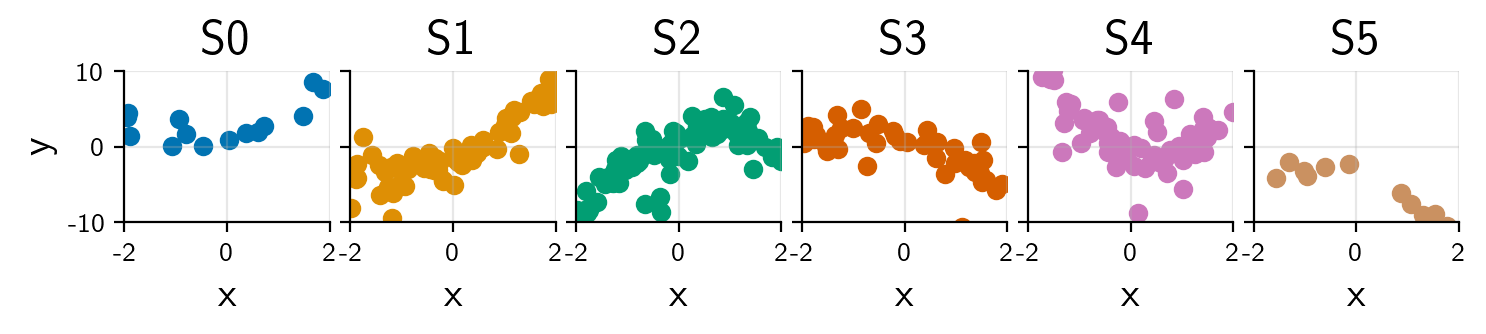

In [160]:
fig, axs = plt.subplots(1, n_segments, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.4))
axs = axs.ravel()
    
for n in np.arange(n_segments):
    axs[n].set_title(f"S{n}")
    color = cmap[n]
    ixs = jnp.where(segment == n)[0]
    xsub = hist_dgp["x"][ixs]
    ysub = hist_dgp["y"][ixs]
    axs[n].scatter(xsub, ysub, color=color)
    axs[n].grid(alpha=0.3)
    axs[n].set_xlabel("x")
    axs[n].set_xlim(-2, 2)
    axs[n].set_ylim(top=10, bottom=-10)
    axs[n].set_yticks([-10, 0, 10], labels=["-10", "0", "10"], fontsize=10)
    axs[n].set_xticks([-2, 0, 2], labels=["-2", "0", "2"], fontsize=10)
    

axs[0].set_ylabel("y")
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("../figures/segments-tdist-lr.png", dpi=300, bbox_inches="tight")

In [161]:
X = hist_dgp["x"]
y = hist_dgp["y"]

## Building the measurment model

In [162]:
def build_features(x, _):
    delta = x# - last_x
    phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
    return phi

def apply_fn(mean, x, bel):
    phi = build_features(x, None)
    yhat =  phi.T @ mean
    return jnp.atleast_1d(yhat)

In [163]:
def callback_static(bel, bel_prior, y, X):
    Ht = build_features(X, None)
    yhat = Ht.T @ bel_prior.mean

    out = {
        "yhat": yhat,
        "err": y - yhat
    }
    return out

In [164]:
def callback(bel, bel_prior, y, X):
    log_posterior = bel_prior.log_joint - jax.nn.logsumexp(bel_prior.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)

    pred_values = jax.vmap(apply_fn, in_axes=(0, None, 0))(bel_prior.mean, X, bel_prior)
    pred = posterior @ pred_values

    Ht = build_features(X, bel_prior.last_x)
    var_pred = jnp.einsum("nk,knm,mk,k->", Ht, bel_prior.cov, Ht, posterior)
    var_pred = var_pred + std_measurements ** 2
    
    out = {
        "log_joint": bel.log_joint,
        "runlength": bel.runlength,
        "err": y - pred,
        "yhat": pred,
        "yhat_var": var_pred,
        "mean": bel.mean
    }
    return out

## RL with moment matching

In [165]:
std_measurements = 1.0

In [166]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=True)

In [167]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[-1])
bel_final, hist_mm = afilter.scan(y, X, bel_init, callback)

In [168]:
log_posterior = hist_mm["log_joint"] - jax.nn.logsumexp(hist_mm["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [169]:
jnp.sqrt(jnp.power(hist_mm["err"], 2).mean())

Array(5.2985125, dtype=float32)

In [170]:
ymin_mm = hist_mm["yhat"].squeeze() - 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())
ymax_mm = hist_mm["yhat"].squeeze() + 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())

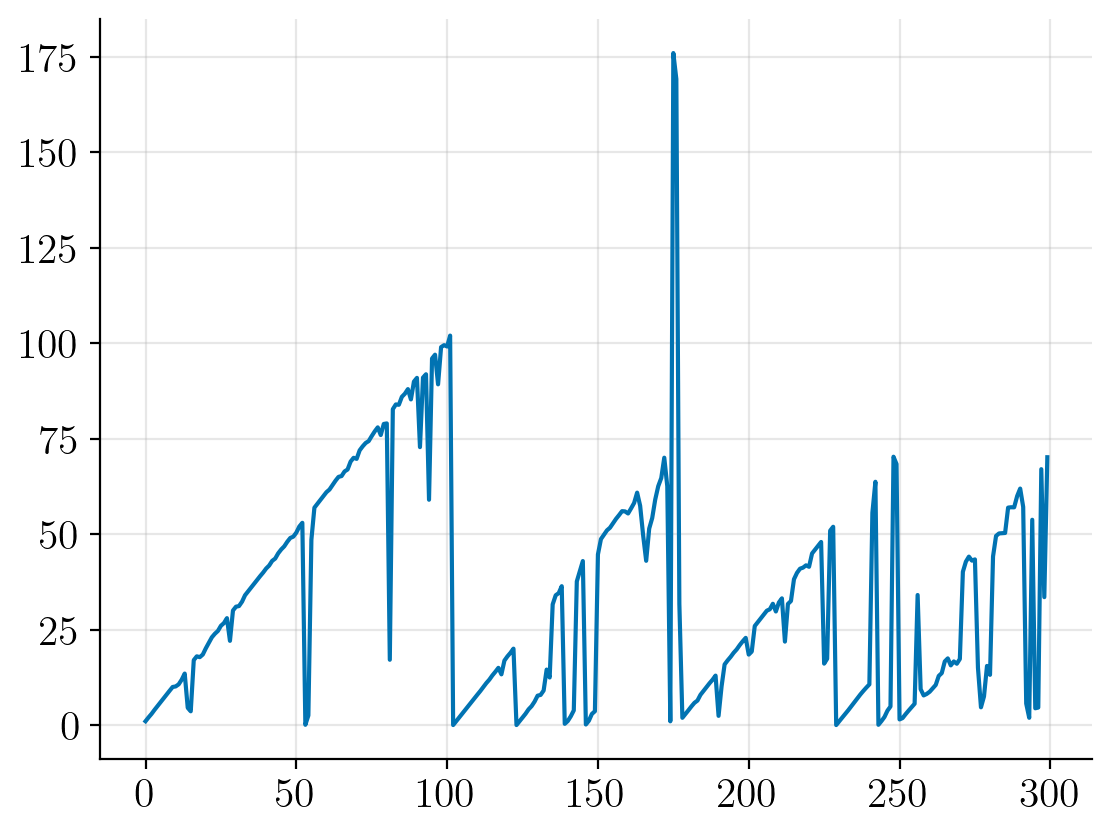

In [171]:
expected_runlength_rlmmpr = jnp.einsum("tk,tk->t", hist_mm["runlength"], posterior)
plt.plot(expected_runlength_rlmmpr)
plt.grid(alpha=0.3)

In [172]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [173]:
runlenght_hist = hist_mm["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

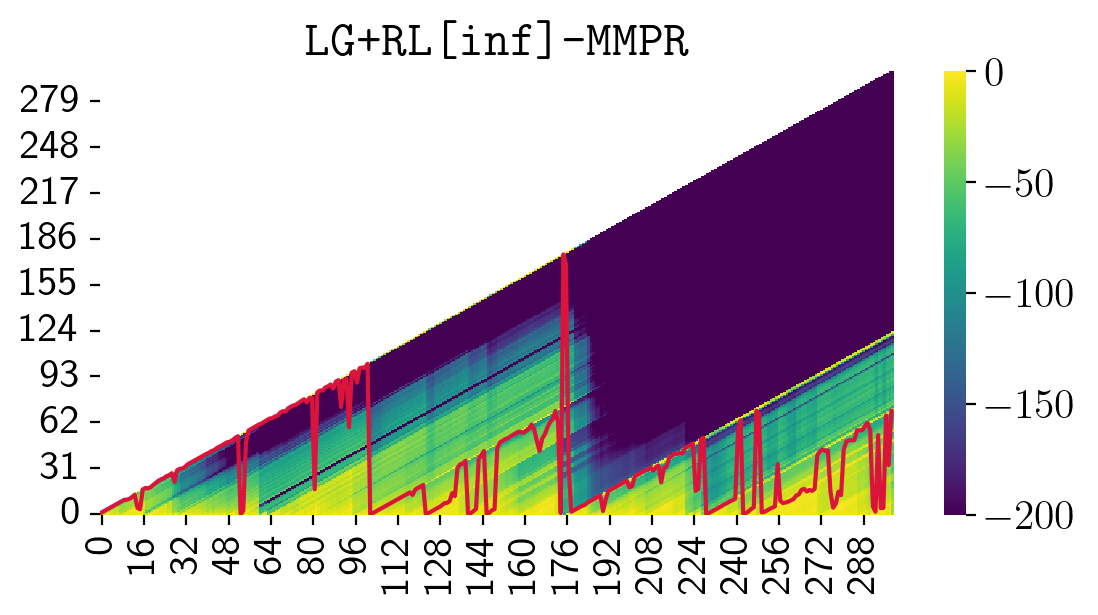

In [174]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))

T = 300
sns.heatmap(log_posterior_grid_sort[:T, :T].T, cmap="viridis", vmin=-200)
# plt.plot(np.nanargmax(log_posterior_grid_sort, axis=1), c="crimson")
plt.plot(expected_runlength_rlmmpr, c="crimson")
plt.title(r"$\texttt{LG+RL[inf]-MMPR}$")
plt.gca().invert_yaxis()

## RL without moment-matching

In [175]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False)

In [176]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
bel_final, hist_rlpr = afilter.scan(y, X, bel_init, callback)

In [177]:
log_posterior = hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
posterior_rlpr = jnp.exp(log_posterior)

In [178]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(4.9976444, dtype=float32)

In [179]:
ymin_rlpr = hist_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())

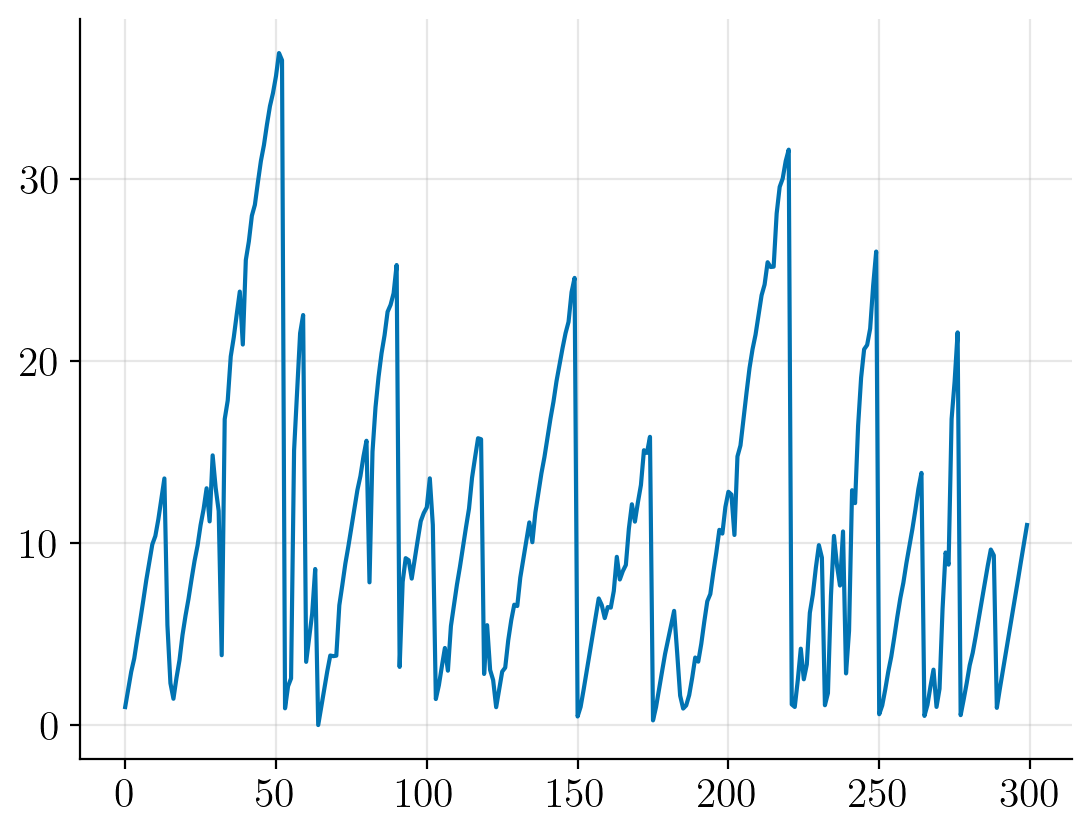

In [180]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_rlpr["runlength"], posterior_rlpr)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

In [181]:
log_posterior = (
    hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
)

In [182]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [183]:
runlenght_hist = hist_rlpr["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort_rlpr = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

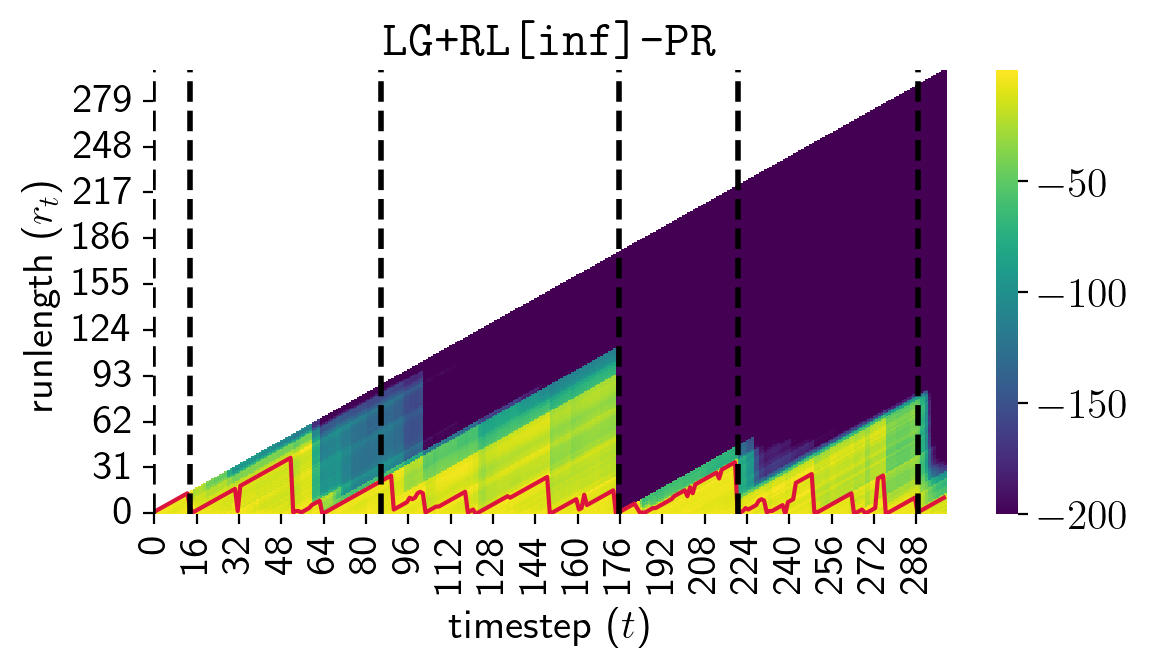

In [184]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))

T = 300
sns.heatmap(log_posterior_grid_sort_rlpr[:T, :T].T, cmap="viridis", vmin=-200)
plt.plot(np.nanargmax(log_posterior_grid_sort_rlpr, axis=1), c="crimson")
plt.gca().invert_yaxis()

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.title(r"$\texttt{LG+RL[inf]-PR}$")
plt.xlabel("timestep ($t$)")
plt.ylabel(r"runlength ($r_t$)")


plt.savefig("../figures/rlpr-tnoise-rl-log-posterior.png", dpi=300, bbox_inches="tight")

## WOLF+RL-PR without moment-matching

In [185]:
c = 6.0
filter = BeliefExtendedKalmanFilterIMQ(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0,
    soft_threshold=c
)
p_change = 0.01
afilter = WoLFPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False, c=c)

In [186]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
bel_final, hist_wolf_rlpr = afilter.scan(y, X, bel_init, callback)

In [187]:
log_posterior = hist_wolf_rlpr["log_joint"] - jax.nn.logsumexp(hist_wolf_rlpr["log_joint"], axis=-1, keepdims=True)
posterior_wolfrlpr = jnp.exp(log_posterior)

In [188]:
jnp.sqrt(jnp.power(hist_wolf_rlpr["err"], 2).mean())

Array(4.623503, dtype=float32)

In [189]:
ymin_rlpr = hist_wolf_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_wolf_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_wolf_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_wolf_rlpr["yhat_var"].squeeze())

In [190]:
log_posterior = (
    hist_wolf_rlpr["log_joint"] - jax.nn.logsumexp(hist_wolf_rlpr["log_joint"], axis=-1, keepdims=True)
)

In [191]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [192]:
runlenght_hist = hist_wolf_rlpr["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort_wolfrlpr = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

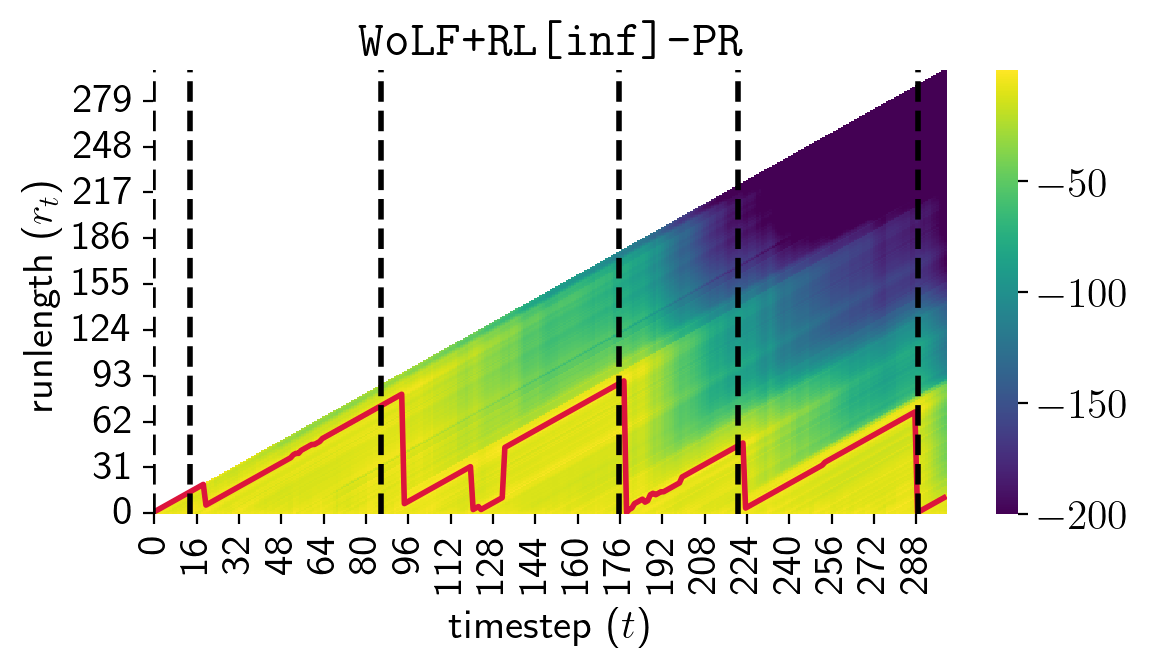

In [193]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))

T = 300
sns.heatmap(log_posterior_grid_sort_wolfrlpr[:T, :T].T, cmap="viridis", vmin=-200)
plt.plot(np.nanargmax(log_posterior_grid_sort_wolfrlpr, axis=1), c="crimson")

plt.plot(hist_wolf_rlpr["runlength"][:, 0], c="crimson", linewidth=2)

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.title(r"$\texttt{WoLF+RL[inf]-PR}$")
plt.xlabel("timestep ($t$)")
plt.ylabel(r"runlength ($r_t$)")


plt.gca().invert_yaxis()
plt.savefig("../figures/rlpr-wolf-tnoise-rl-log-posterior.png", dpi=300, bbox_inches="tight")

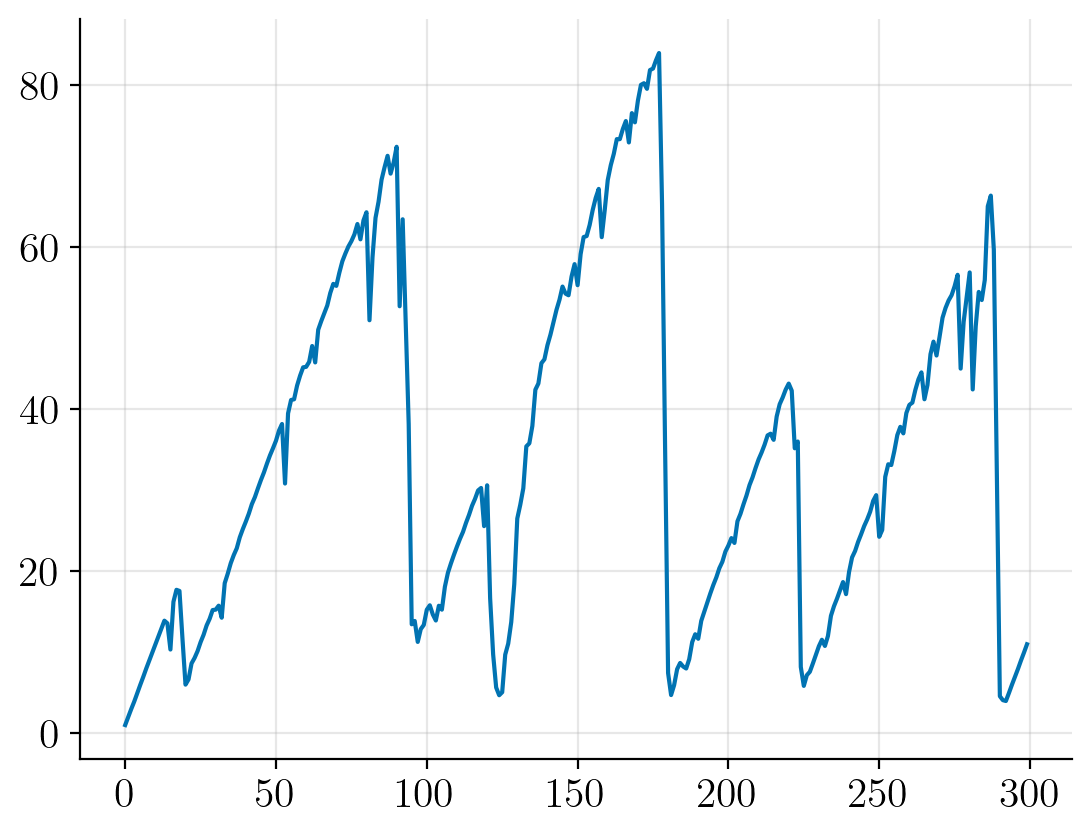

In [194]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_wolf_rlpr["runlength"], posterior_wolfrlpr)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

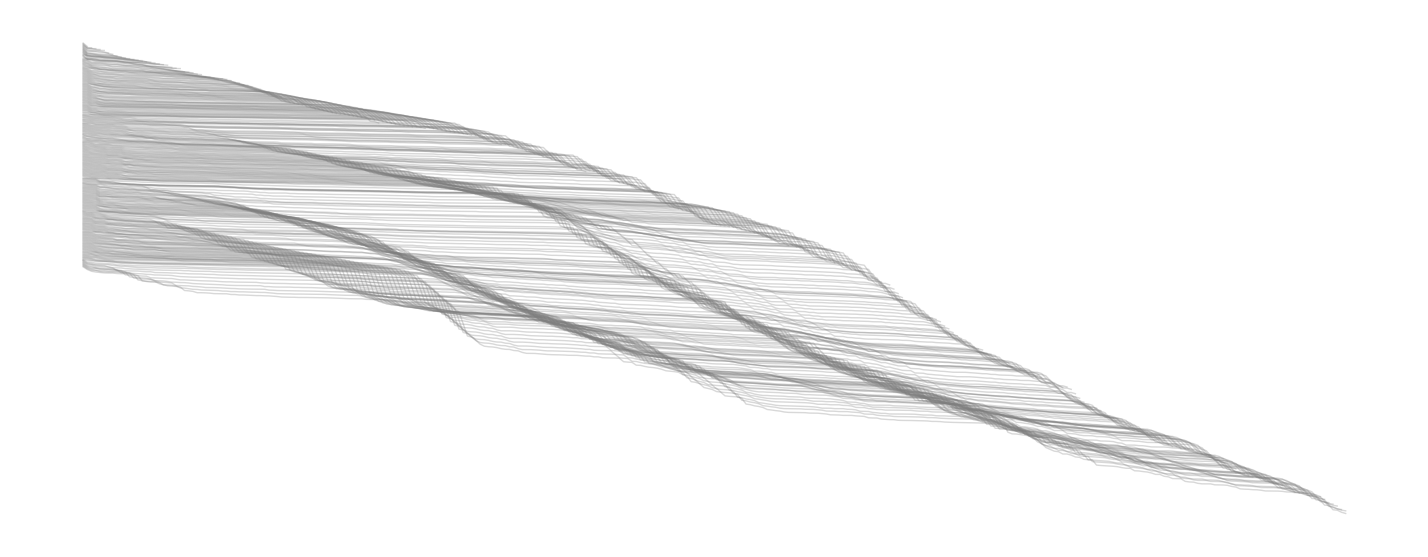

In [195]:
fig, ax = plt.subplots(figsize=(6.4 * 1.4, 4.2 * 0.8))
for i in range(0, 300):
    plt.plot(-i + log_posterior_grid[i], c="tab:gray", alpha=0.3, linewidth=0.5)
plt.axis("off")
plt.savefig("../figures/abstract-logrid.png", dpi=300, bbox_inches="tight")

# Animation

In [196]:
from matplotlib.animation import FuncAnimation

In [197]:
Xcpu = np.array(X.squeeze())
ycpu = np.array(y.squeeze())
segment_cpu = np.array(segment)
hist_mean = hist_rlpr["mean"]

In [198]:
ixs_segments = {
    n: np.where(segment == n)[0]
    for n in range(n_segments)
}

In [199]:
x_test = np.linspace(-2,2, 100)
Phi_test = build_features(x_test, None).T

In [200]:
np.quantile(ycpu, 0.95)

np.float32(8.508719)

In [201]:
np.quantile(ycpu, 0.05)

np.float32(-7.581992)

## Both

In [202]:
from matplotlib.gridspec import GridSpec

/tmp/ipykernel_1163507/41582592.py:59: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


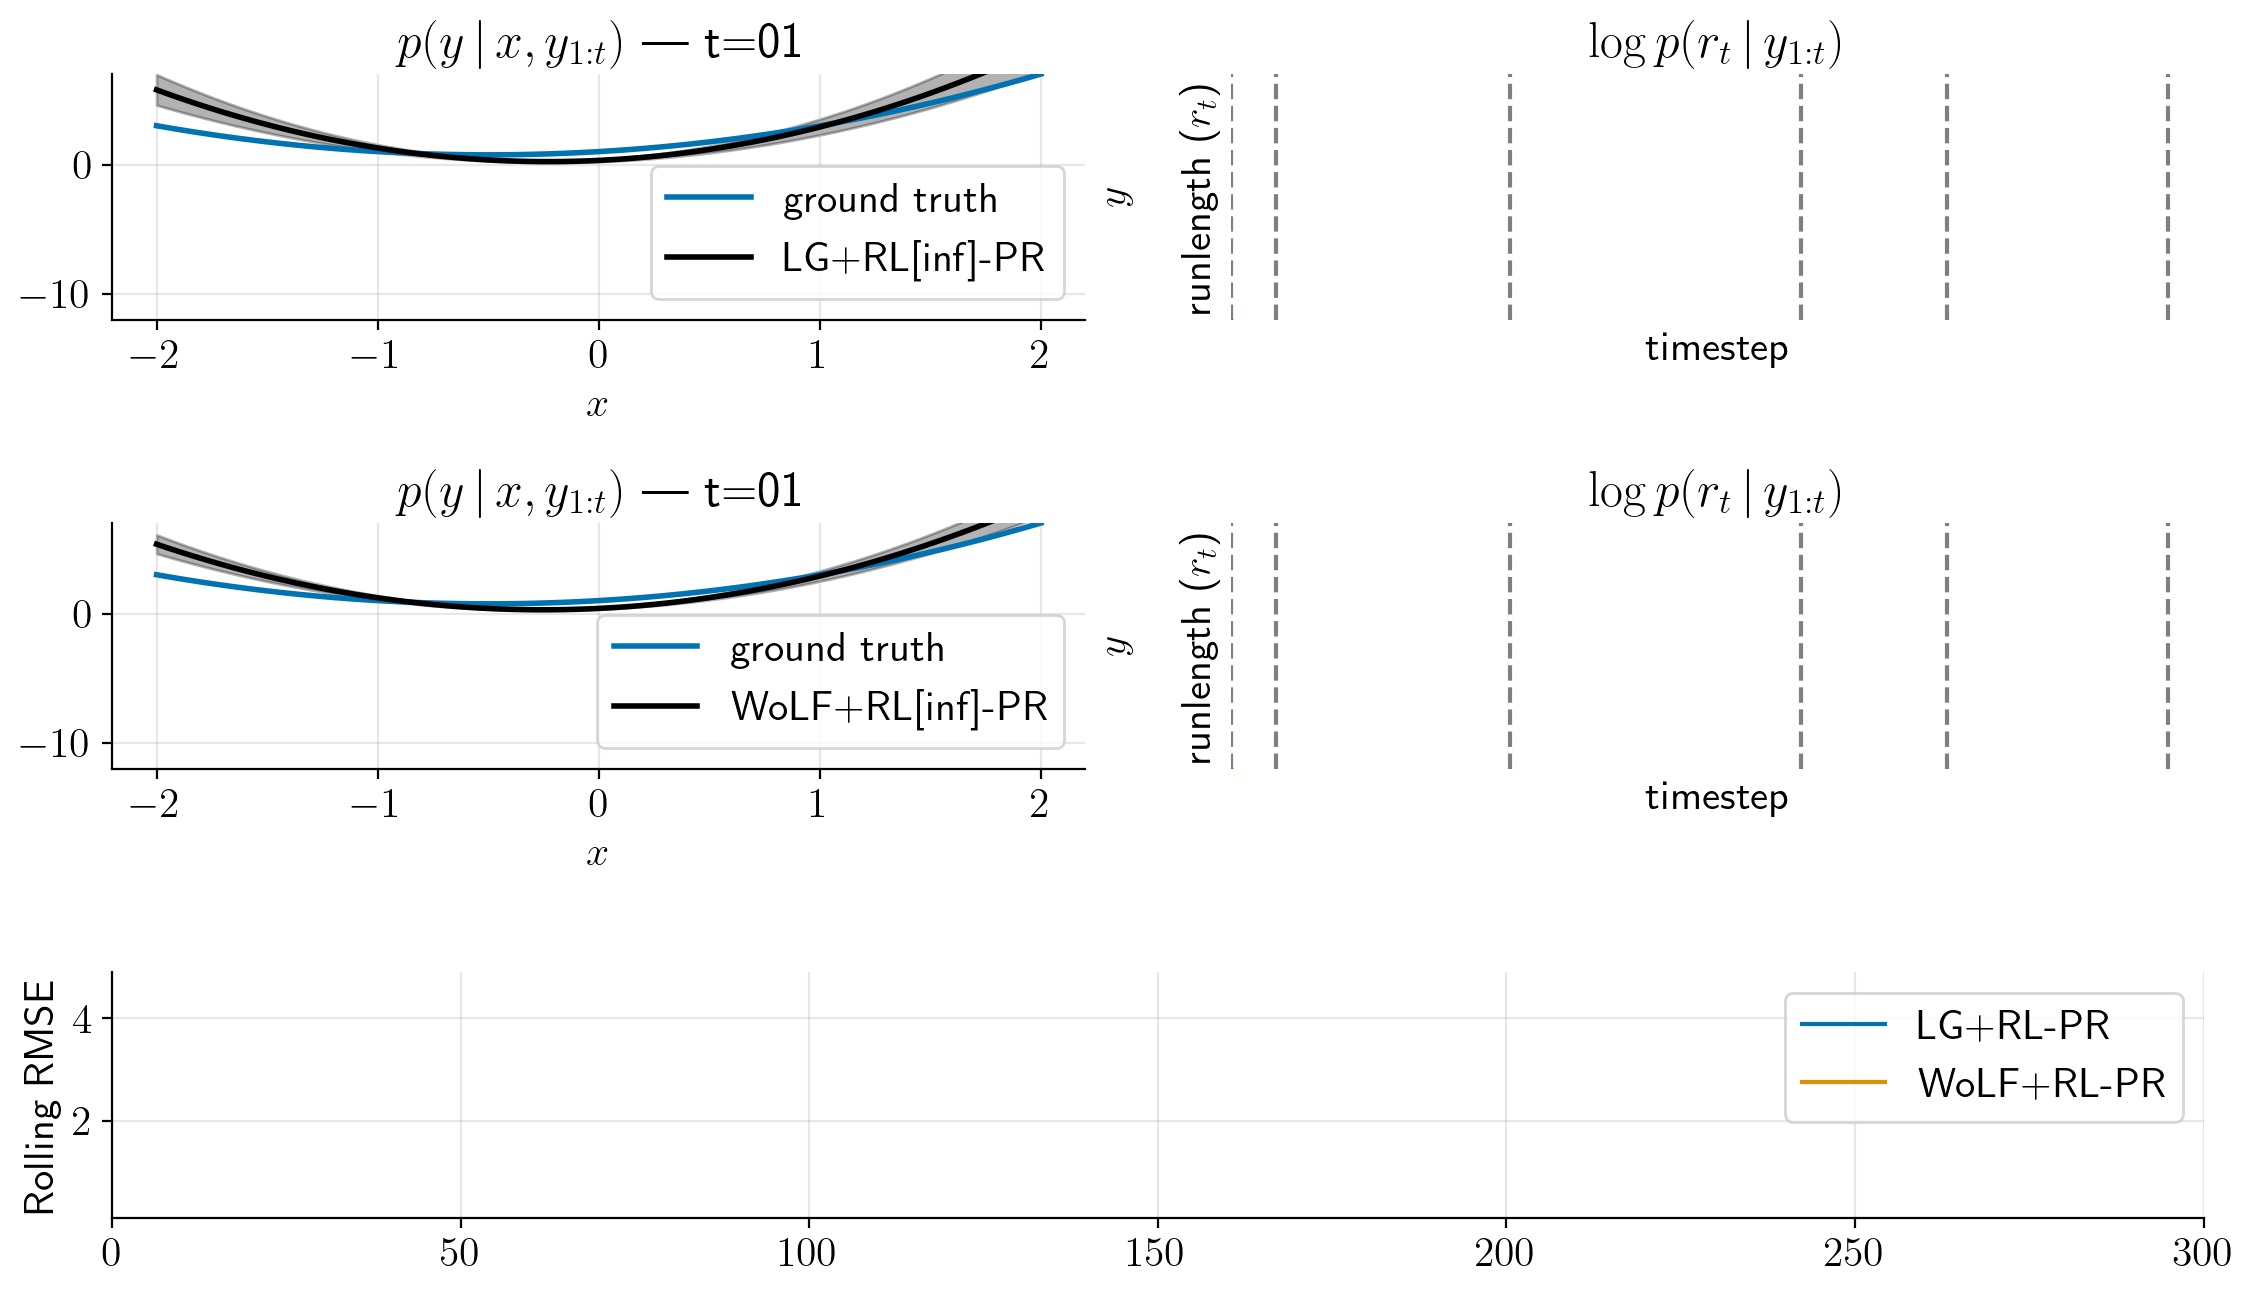

In [250]:
# fig, axs_all = plt.subplots(2, 2, figsize=(6.4 * 1.8, 4.8 * 0.7 * 2))

fig = plt.figure(figsize=(6.4 * 1.8, 4.8 * 0.7 * 2))
gs = GridSpec(3, 2)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])

ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])

ax2 = fig.add_subplot(gs[2, :])

axs_all = np.array([(ax00, ax01), (ax10, ax11)])

xeval = Phi_test[:, 1]
hist_mean_wolf = hist_wolf_rlpr["mean"]
hist_mean_lg = hist_rlpr["mean"]

yclean = np.array(hist_dgp["yclean"]).ravel()

err_wolf = np.power(pd.Series(hist_wolf_rlpr["yhat"].ravel() - yclean), 2)
err_rlpr = np.power(pd.Series(hist_rlpr["yhat"].ravel() - yclean), 2)

errs2 = pd.DataFrame({
    "LG+RL-PR": err_rlpr,
    "WoLF+RL-PR": err_wolf
})

posteriors = [posterior_rlpr, posterior_wolfrlpr]
hist_means = [hist_mean_lg, hist_mean_wolf]
log_grids = [log_posterior_grid_sort_rlpr, log_posterior_grid_sort_wolfrlpr]
labels = ["LG+RL[inf]-PR", "WoLF+RL[inf]-PR"]

yerr = np.sqrt(errs2.rolling(10).mean())
yerrmin = np.nanmin(yerr.values)
yerrmax = np.nanmax(yerr.values)

def animate(t):
    for ax in axs_all.ravel():
        ax.cla()
    ax2.cla()
    print(t, end="\r")

    s = segment_cpu[t]
    params_true = hist_dgp["params"][t]
    t_init = ixs_segments[s][0]
    
    ix_init = 0
    ix_end = t
    tmin = max(0, t - 150)
    alpha_vals = jnp.linspace(0, 1, len(y.squeeze()[tmin:t]))

    ytrue = np.einsum("nm,m->n", Phi_test, params_true)

    for axs, label, hist_mean, posterior, log_grid in zip(axs_all, labels, hist_means, posteriors, log_grids):
        yhat = np.einsum("sm,km->sk", Phi_test, hist_mean[t,:t+2])
        yhat_mean = np.einsum("sk,k-> s", yhat, posterior[t,:t+2])
        yhat_std = np.sqrt(
            jnp.einsum("sk,k-> s", yhat ** 2, posterior[t,:t+2]) - yhat_mean ** 2
        )
    
        axs[0].plot(xeval, ytrue, c=colors[t], linewidth=2, label="ground truth")
        axs[0].plot(xeval, yhat_mean, c="black", linewidth=2, label=label)
        axs[0].fill_between(xeval, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="black", alpha=0.3)
        
        axs[0].scatter(Xcpu[tmin:t], ycpu[tmin:t], c=colors[tmin:t], alpha=alpha_vals)
        
        axs[0].grid(alpha=0.3)
        axs[0].set_ylim(-12, 7)
        axs[0].set_xlabel("$x$")
        axs[0].set_ylabel("$y$")
        axs[0].yaxis.set_label_position("right")
        axs[0].set_title(r"$p(y\,\vert\,x, y_{1:t})$"f" | t={t:02}")
        axs[0].legend(loc="lower right")
        axs[0].grid(alpha=0.3)
        axs[0].set_xlabel("$x$")
        axs[0].set_ylabel("$y$")
    
        sns.heatmap(
            log_grid.T[:t, :t], cbar=False, vmin=-200, cmap="viridis", ax=axs[1],
            xticklabels=False, yticklabels=False
        )
        axs[1].plot(np.nanargmax(log_grid[:t], axis=1), c="crimson")
        axs[1].invert_yaxis()
        axs[1].set_xlim(0, 300)
        axs[1].set_ylim(0, 300)
        
        for s in segments_init:
            axs[1].axvline(x=s, c="black", linestyle="--", alpha=0.5)
        axs[1].set_xlabel("timestep")
        axs[1].set_ylabel("runlength ($r_{t}$)")
        axs[1].set_title(r"$\log p(r_{t}\,\vert\,y_{1:t})$")

    np.sqrt(errs2.rolling(min(t, 20)).mean())[:t].plot(ax=ax2)
    ax2.set_xlim(0, 300)
    ax2.grid(alpha=0.3)
    ax2.set_ylabel("Rolling RMSE")
    ax2.set_ylim(yerrmin, yerrmax)
    plt.tight_layout()

# animate(50)

anim = FuncAnimation(fig, animate, np.arange(1, 300))
anim.save("../figures/outliers-all-panel.mp4", fps=10)

# Simulations

In [58]:
n_sims = 50
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)

In [59]:
vhist = jax.vmap(sample_run, in_axes=(0, None, None))(keys, n_samples, p_change)

In [60]:
@jax.vmap
def rlpr_run(y, X):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
    )
    p_change = 0.01
    afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
    bel_final, hist_rlpr = afilter.scan(y, X, bel_init, callback)
    return hist_rlpr["yhat"]

@partial(jax.vmap, in_axes=(0, 0, None))
def wolf_rlpr_run(y, X, c):
    filter = BeliefExtendedKalmanFilterIMQ(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0,
        soft_threshold=c
    )
    p_change = 0.01
    afilter = WoLFPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False, c=c)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
    bel_final, hist_wolf_rlpr = afilter.scan(y, X, bel_init, callback)
    return hist_wolf_rlpr["yhat"]

@jax.vmap
def static_run(y, X):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
    )

    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0

    bel_init = filter.init_bel(mean, cov)
    bel_final, hist = filter.scan(bel_init, y, X, callback_static)
    return hist["yhat"]

In [61]:
vy = vhist["y"]
vy_clean = vhist["yclean"]
vX = vhist["x"]
vchanges = vhist["change"]

In [62]:
err_rlpr_hist = rlpr_run(vy, vX)

In [63]:
err_static = static_run(vy, vX)

In [64]:
c = 4.0
err_wolf_rlpr_hist = wolf_rlpr_run(vy, vX, c)

In [65]:
df_all = {
    "WoLF+RL[inf]-PR": err_wolf_rlpr_hist,
    "LG+RL[inf]-PR": err_rlpr_hist,
    "LG+C+Static": err_static,
}

df_all = jax.tree.map(lambda x: (x - vy_clean).squeeze(), df_all)

# df_res = jax.tree.map(lambda x: np.sqrt(np.median(np.power(x, 2), axis=1)), df_all)
df_res = jax.tree.map(lambda x: np.sqrt(np.mean(np.power(x, 2), axis=1)), df_all)
df_res = pd.DataFrame(df_res)
df_res.columns = [r"$\texttt{" + c + "}$" for c in df_res.columns]

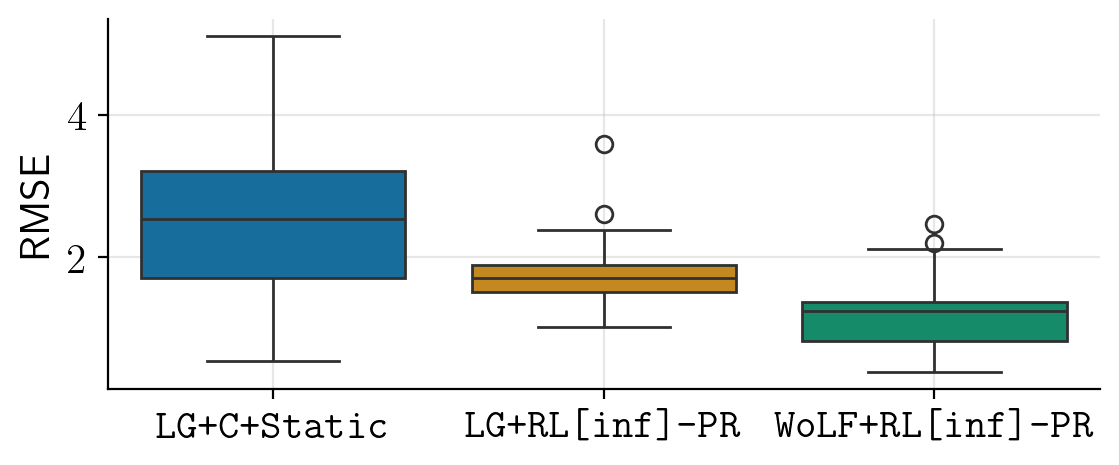

In [66]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

sns.boxplot(
    x="variable",
    y="value",
    hue="variable",
    data=df_res.melt(),
)
plt.ylabel("RMSE")
plt.grid(alpha=0.3)
plt.xlabel("")
plt.savefig("../figures/rl-pr-outliers-res.png", dpi=300, bbox_inches="tight")

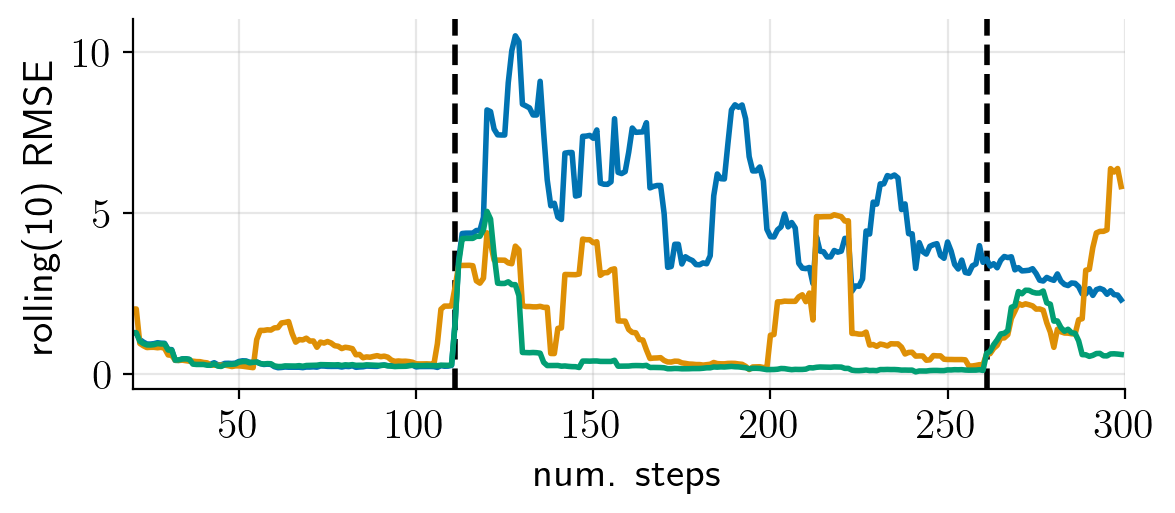

In [67]:
s = 36

segment = np.array(vchanges[s].cumsum())
n_segments = len(np.unique(segment))
n_segments

n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))


sim = jax.tree.map(lambda x: np.array(x[s]), df_all)
sim = pd.DataFrame(sim)
sim.columns = [r"$\texttt{" + c + "}$" for c in sim.columns]

for s in segments_init[1:]:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.ylabel("rolling(10) RMSE")
plt.xlabel("num. steps")
plt.xlim(20, 300)
np.sqrt(np.power(sim, 2).rolling(10).mean()).plot(linewidth=2, ax=ax)
# plt.legend(loc="upper right", handlelength=0.5)
plt.legend([], frameon=False)

plt.grid(alpha=0.3)
plt.savefig("../figures/rl-pr-outliers-sample-run.png", dpi=300, bbox_inches="tight")